In [1]:
import pandas as pd
import numpy as np
import pickle
import requests
import bs4 as bs
import pandas_datareader as web
import fix_yahoo_finance as yf
import datetime as dt
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style, RcParams
import mpl_finance as finance
import matplotlib.ticker as ticker
from matplotlib.dates import date2num, DayLocator, DateFormatter
pd.core.common.is_list_like = pd.api.types.is_list_like
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pmdarima import auto_arima
import talib as ta
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, TimeDistributed, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.cluster import KMeans

Using TensorFlow backend.


# Outline

* Exploratory data analysis (EDA)
* Set up features (volatility, oscillator indicators, etc) for analysis
* Set up buy and sell signals for different strategies
* build ARIMA model
* build LSTM model
* compare signaling for the models
* run backtesting to test strategy

In [2]:
style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7) # Setting default params for figures

In [3]:
close_df = pd.read_csv('sp500_close_joined.csv', index_col=0)
close_df.dropna(axis=1, inplace=True)

In [4]:
print(close_df.shape)
close_df.tail()

(1259, 472)


,MMM,ABT,ABBV,ABBV.1,ACN,ATVI,ADBE,AMD,AAP,AES,...,WMB,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,247.94,62.18,116.34,116.34,160.46,73.35,199.38,13.25,117.29,11.51,...,31.68,170.49,44.81,32.75,72.49,74.84,83.98,128.19,54.98,77.82
2018-02-02,245.17,61.69,115.17,115.17,156.90,71.42,195.64,12.45,113.93,11.12,...,30.70,166.56,44.48,31.63,70.64,75.66,82.63,125.79,54.15,76.78
2018-02-05,231.44,58.73,109.51,109.51,151.83,67.98,190.27,11.57,109.86,10.60,...,29.48,165.48,43.63,31.38,66.97,72.66,79.80,123.18,51.65,73.83
2018-02-06,233.63,58.86,111.20,111.20,154.69,69.70,194.47,11.65,112.20,10.58,...,30.17,163.22,42.73,30.85,68.99,71.33,80.58,122.30,52.52,73.27
2018-02-07,233.19,58.67,113.62,113.62,155.15,69.46,192.34,11.60,109.93,10.48,...,30.00,177.32,42.46,31.18,66.97,71.79,80.13,120.78,54.02,73.86


Still left with 472 companies after accounting for missing values in dates, although there seems ot be some repeats. We can take care of that later.

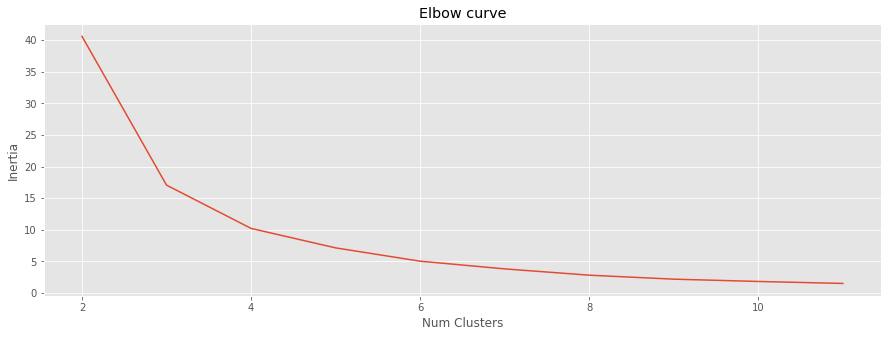

In [5]:
close_df = close_df.loc['2017-02-07':'2018-02-07']
returns = close_df.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = close_df.pct_change().std() * np.sqrt(252)
 
#format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
scalar = Normalizer()
X = scalar.fit_transform(data)
distortions = []
for k in range(2, 12):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 12), distortions)
plt.xlabel("Num Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.title('Elbow curve')
plt.show()

We see from the above elbow plot that the KMeans algorithm minimizes inertia, a metric for the sum of thee squared distance of each point from the centroid, at around 6 clusters. Let's plot the clusters to see what the split looks like

In [6]:
kmeans = KMeans(n_clusters=6, random_state=5)
model_fit = kmeans.fit_predict(X)
model_results = pd.DataFrame(model_fit, index=close_df.columns, columns=['cluster_prediction'])
model_results = pd.concat([returns, model_results], axis=1)
model_results = model_results.rename(columns={'Returns': 'yearly_returns', 'Volatility': 'yearly_volatility'})
model_results = model_results.drop_duplicates()

In [7]:
def sp500_company_info():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    sectors = []
    industries = []
    for row in table.findAll('tr')[1:]:
        sector = row.findAll('td')[3].text
        industry = row.findAll('td')[4].text
        sectors.append(sector)
        industries.append(industry)
    return sectors, industries

with open('sp500tickers.pickle', 'rb') as f:
    tickers = pickle.load(f)
sectors, industries = sp500_company_info()
sectors_df = pd.DataFrame(sectors, index=tickers, columns=['sector'])
industry_df = pd.DataFrame(industries, index=tickers, columns=['industry'])
index = [x for x in sectors_df.index if x in model_results.index]
sectors_df = sectors_df.loc[index]
industry_df = industry_df.loc[index]

In [8]:
model_results = pd.concat([sectors_df, industry_df, model_results], axis=1)

In [9]:
model_results.head()

,sector,industry,yearly_returns,yearly_volatility,cluster_prediction
MMM,Industrials,Industrial Conglomerates,0.294038,0.149420,0
ABT,Health Care,Health Care Equipment,0.324978,0.152017,0
ABBV,Health Care,Pharmaceuticals,0.658235,0.241519,0
ACN,Information Technology,IT Consulting & Other Services,0.301089,0.137168,0
ATVI,Communication Services,Interactive Home Entertainment,0.601048,0.322057,0


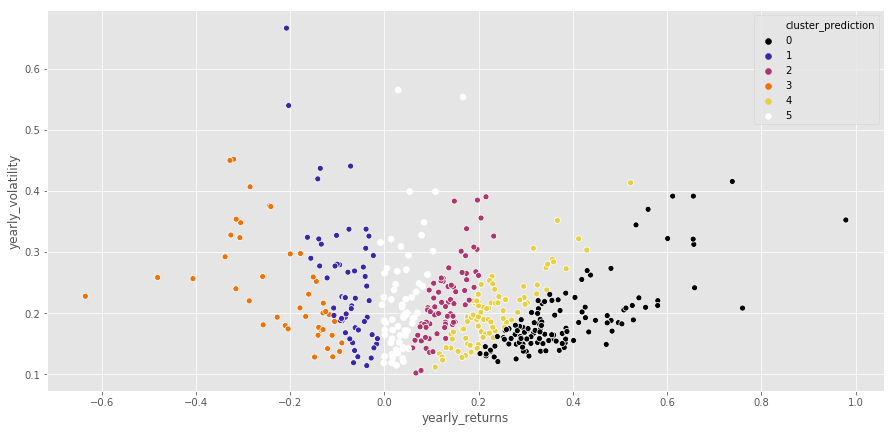

In [10]:
sns.scatterplot(model_results.yearly_returns, 
                model_results.yearly_volatility, 
                hue=model_results.cluster_prediction,
                palette='CMRmap',
                legend='full'
               )
plt.show()

In [11]:
pred_5 = model_results.loc[model_results.cluster_prediction==5, ['yearly_returns', 'sector', 'industry']]
print("Cluster 5 results")
pred_5['sector'].value_counts()

Cluster 5 results


Utilities                 15
Energy                     9
Health Care                9
Consumer Discretionary     8
Financials                 7
Industrials                6
Information Technology     4
Materials                  3
Consumer Staples           3
Real Estate                2
Name: sector, dtype: int64

In [12]:
pred_4 = model_results.loc[model_results.cluster_prediction==4, ['yearly_returns', 'sector', 'industry']]
print('Cluster 4 results')
pred_4['sector'].value_counts()

Cluster 4 results


Industrials               23
Financials                19
Consumer Discretionary    15
Information Technology     9
Health Care                9
Materials                  6
Energy                     2
Real Estate                2
Utilities                  2
Name: sector, dtype: int64

In [13]:
pred_3 = model_results.loc[model_results.cluster_prediction==3, ['yearly_returns', 'sector', 'industry']]
print('Cluster 3 results')
pred_3['sector'].value_counts()

Cluster 3 results


Real Estate               13
Consumer Discretionary     6
Energy                     5
Consumer Staples           4
Communication Services     4
Health Care                3
Utilities                  3
Industrials                2
Information Technology     1
Materials                  1
Name: sector, dtype: int64

In [14]:
pred_2 = model_results.loc[model_results.cluster_prediction==2, ['yearly_returns', 'sector', 'industry']]
print('Cluster 2 results')
pred_2['sector'].value_counts()

Cluster 2 results


Information Technology      11
Financials                  11
Industrials                 10
Health Care                  8
Materials                    7
Consumer Staples             7
Consumer Discretionary       6
Real Estate                  4
Energy                       3
Utilities                    2
Communication Services       2
Communication Services\n     1
Name: sector, dtype: int64

In [15]:
pred_1 = model_results.loc[model_results.cluster_prediction==1, ['yearly_returns', 'sector', 'industry']]
print('Cluster 1 results')
pred_1['sector'].value_counts()

Cluster 1 results


Consumer Staples          11
Consumer Discretionary     7
Communication Services     7
Energy                     6
Health Care                5
Industrials                5
Real Estate                5
Financials                 3
Information Technology     3
Utilities                  3
Materials                  1
Name: sector, dtype: int64

In [16]:
pred_0 = model_results.loc[model_results.cluster_prediction==0, ['yearly_returns', 'sector', 'industry']]
print('Cluster 0 results')
pred_0['sector'].value_counts()

Cluster 0 results


Information Technology    24
Health Care               21
Financials                21
Industrials               18
Consumer Discretionary    17
Communication Services     5
Consumer Staples           5
Materials                  4
Real Estate                2
Energy                     1
Name: sector, dtype: int64

This gives us an idea of how our clustering algorithm separated multiple companies based on thier returns and volatilites from Feb 2017 to Feb 2018. Now let's start exploring trading strategies on a single stock to see how we can begin trading algorithmically.

## Visualizing stock information

There are usually 5 main features that form the basis for all stock market information and allow us to create a great many features to describe the data. The are the open, close, high, low, and volume. The first 4 variables are the price values for a stock at any given day and voulme is the number of shares being traded at that point. One important note is that there is a value called adjusted close, which refers to the close price in relation to the volume. During certain periods of time, a company may double the amount of stocks being shared, which causes the price of the close to fall by half. The stocks are still worth essentially the same, it's just a change in how the data is presented in the stock market. Because of this and many other changes that may occur in the stock market, the adjusted close is the value that takes into account these changes, thus it will be our value of interest. 

In [17]:
# quandl has yet to include all of 2018's data so we will use a window from 2016-2018
start = '2017-01-01'
end = '2019-03-25'
aapl_df = yf.download('AAPL', start, end)

[*********************100%***********************]  1 of 1 downloaded


In [18]:
aapl_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-19,188.350006,188.990005,185.919998,186.529999,186.529999,31646400
2019-03-20,186.229996,189.490005,184.729996,188.160004,188.160004,31035200
2019-03-21,190.020004,196.330002,189.809998,195.089996,195.089996,51034200
2019-03-22,195.339996,197.690002,190.779999,191.050003,191.050003,42407700
2019-03-25,191.509995,191.979996,186.600006,188.740005,188.740005,43845300


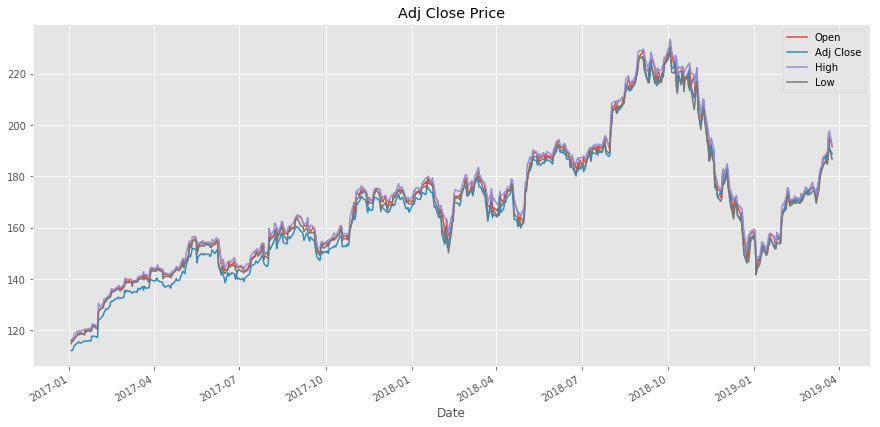

In [19]:
#Past trading years closing price
aapl_df['Open'][:].plot(kind='line')
aapl_df['Adj Close'][:].plot(kind='line')
aapl_df['High'][:].plot(kind='line')
aapl_df['Low'][:].plot(kind='line')
plt.title('Adj Close Price')
plt.legend()
plt.show()

# Interpreting a candlebar graph

Regular line graphs are good and all for most numerical visualization, but finance data requires quite a bit of overlayed data which can be hard to read with traditional graphing methods. In order to remedy this, we will use something simple called Japanese Candlebar Graphs in order to visualize a great breadth of information. 

The candlebar graph conbeys a particular stock's high, low, open, and close prices for a given time period. The flat ends of the bar part of the graph represent the open and close price. The wicks coming out of the bars are indicators for the high and low price for that particular day. The addition of color changes how one reads the graphs.

The colors of the graph indicate direction of stock price for a given day. If a bar is green, then that means the stock was in an uptrend for the day and it closed higher than it opened for. With that in mind, the top wick indicates the days price high and the bottom wick indicates the days price low. The upper bart of the bar shows the close price and the lower part shows the days open price. 

When the bars are red, the major difference is that the indicators for the bars are switched. In red bars, the top part of the bar represents the open price and the bottom part represents the close price. The lines still hold their original meaning no matter the color. 

Now the color can be changed to any type we want but usually, downstrends are red and uptrends are either green or black. 

Armed with this knowledge, and with practice over time, one may graze over these graphs and gather a large amount of information and eventually form heuristics for price trends. 

In [20]:
aapl_df['Date'] = aapl_df.index.map(lambda x: date2num(x))
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2017-01-03,115.800003,116.330002,114.760002,116.150002,112.140007,28781900,736332.0
2017-01-04,115.849998,116.510002,115.750000,116.019997,112.014503,21118100,736333.0
2017-01-05,115.919998,116.860001,115.809998,116.610001,112.584129,22193600,736334.0
2017-01-06,116.779999,118.160004,116.470001,117.910004,113.839249,31751900,736335.0
2017-01-09,117.949997,119.430000,117.940002,118.989998,114.881950,33561900,736338.0


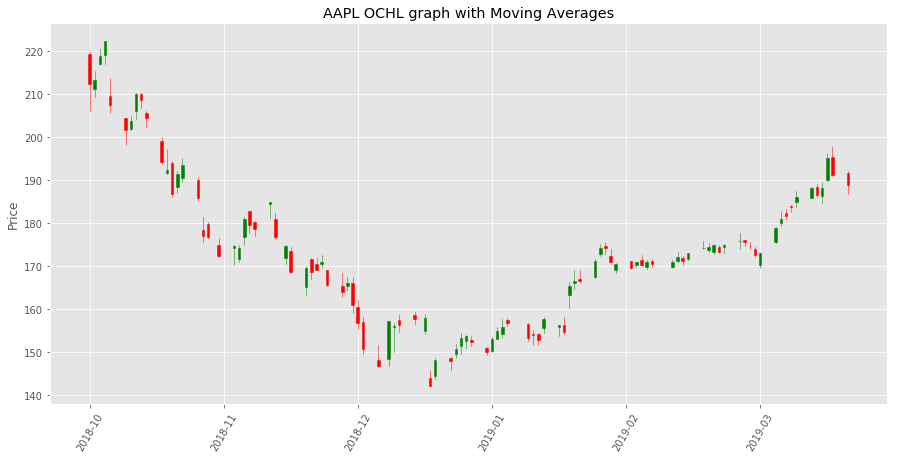

In [21]:
start=-100
fig, ax = plt.subplots()

finance.candlestick_ochl(ax,
                         quotes=aapl_df[['Date', 'Open', 'Close', 'High', 'Low']][start:].values,
                         width=.5,
                         colorup='green'
                         )
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(26))
plt.xticks(rotation=60)
plt.ylabel("Price")
plt.title("AAPL OCHL graph with Moving Averages")
plt.show()

# Overlays - Technical indicators that overlap price movement

### Trend indicators - SMA, EMA, KAMA

A simple way to find trends in stocks is instead of looking at price day to day, we look at the averages price over a given interval of time. This is known as a moving average (MA). There are 2 main types of moving averages in technical analysis and each has its own advantages and disadvantages. 

There is the simple moving average (SMA) and the exponential moving average (EMA). The SMA is useful in that it provides a smooth trend curve that is easy to interpret and works well for long term trends. However, it's not very responsive to sharp changes in the market which may be caused by a reversal in the stock trend. 

The EMA is beneficial in that it's weighted by the most recent price so changes in stock price are more palpable in this measure. This makes it so that some data from the past which may be irrelevant is not considered as highly in finding the trend. The problem with this is that it can lead to very jagged trends and is prone to false signals/noise. 

The SMA is a good component to use if we have a longer time frame in mind such as with daily or weekly data. The EMA is more useful in an intraday trading strategy in which stock data is given every 15 minutes or some measure close ot that. In the context of this project, we are looking at long term trading and not necessarily day trading which is very risky and requires a good investment of time, therefor we will use the SMA. 

# Volatility - a measure of the potential spread of a price stock within a time period

Volatility measures allow us to set up signals to enter or exit our position in stocks by seeing a volatile a stock is. Trends in volatility usually follow a pattern of low volatility to high volatility. Volatility doesn't show direction of the stock price but rather how far it can deviate from the current mean trend it has. Volatility can be measured as a simple rolling standard deviation of a given window to the range of price spreads per day averaged to a particular window size. There are many volatility measures and we will try to pick the best one for our purposes, but once again this is very dependent on the company, sector, time period. 

Another measure of volatility that is common is average true range.

### True range (TR) and Average True Range (ATR)

__TR__: max value between 3 methods

_Method 1: Current High minus the current Low_

_Method 2: Current High minus the previous Close (absolute value)_

_Method 3: Current Low minus the previous Close (absolute value)_

__ATR__: Calculated based on 14 periods. For stock data, weekends are not included so 14 periods is roughly 3 weeks of data.

$$Current ATR = [(ATR_P) * 13) + ATR_C] / 14$$

Where the P is prior and C is current in the ATR variables.

ATR requires a good deal of data to deliver valuable insight, so if we have little daily data, then our volatility index might be affected.

In [22]:
# Feature engineering. These will be explained further down the notebook
def set_spreads(items):
    items['High-Low'] = items['High'] - items['Low']
    items['|H-Cp|'] = np.abs(items['High'] - items['Adj Close'].shift(1))
    items['|L-Cp|'] = np.abs(items['Low'] - items['Adj Close'].shift(1))
    items['Open-Close'] = items['Open'] - items['Adj Close']
    items['Open-High'] = items['Open'] - items['High'].shift(1)
    items['Open-Low'] = items['Open'] - items['Low'].shift(1)
    #items['gap_up'] = np.where(items['Open-High']>0, 1, 0)
    #items['gap_down'] = np.where(items['Open-Low']<0, 1, 0)

    # Volatility
    items['TR'] = items[['High-Low', '|H-Cp|', '|L-Cp|']].max(axis=1)
    items['ATR_5'] = np.divide(items['TR'].rolling(5, min_periods=0).sum(), 5) #Calculating moving average of TR for a standard trading week
    items['ATR_14'] = np.divide(items['TR'].rolling(14, min_periods=0).sum(), 14)


    # Overlay measures
    items['5_MA'] = items['Adj Close'].rolling(5, min_periods=0).mean()
    items['20_MA'] = items['Adj Close'].rolling(20, min_periods=0).mean() #The moving average for a usual monthly trading period
    items['50_MA'] = items['Adj Close'].rolling(50, min_periods=0).mean()
    items['100_MA'] = items['Adj Close'].rolling(100, min_periods=0).mean()

    items['5_EMA'] = items['Adj Close'].ewm(span=5, adjust=False).mean()
    items['20_EMA'] = items['Adj Close'].ewm(span=20, adjust=False).mean()
    items['50_EMA'] = items['Adj Close'].ewm(span=50, adjust=False).mean()
    items['100_EMA'] = items['Adj Close'].ewm(span=100, adjust=False).mean()

        
set_spreads(aapl_df)

In [23]:
aapl_df[['Open', 'Adj Close', 'High', 'Low', 'High-Low', '|H-Cp|', '|L-Cp|', 'ATR_5', 'ATR_14']].head()

,Open,Adj Close,High,Low,High-Low,|H-Cp|,|L-Cp|,ATR_5,ATR_14
Date,,,,,,,,,
2017-01-03,115.800003,112.140007,116.330002,114.760002,1.570000,NaN,NaN,0.314000,0.112143
2017-01-04,115.849998,112.014503,116.510002,115.750000,0.760002,4.369995,3.609993,1.187999,0.424285
2017-01-05,115.919998,112.584129,116.860001,115.809998,1.050003,4.845498,3.795495,2.157099,0.770392
2017-01-06,116.779999,113.839249,118.160004,116.470001,1.690003,5.575875,3.885872,3.272274,1.168669
2017-01-09,117.949997,114.881950,119.430000,117.940002,1.489998,5.590751,4.100753,4.390424,1.568008


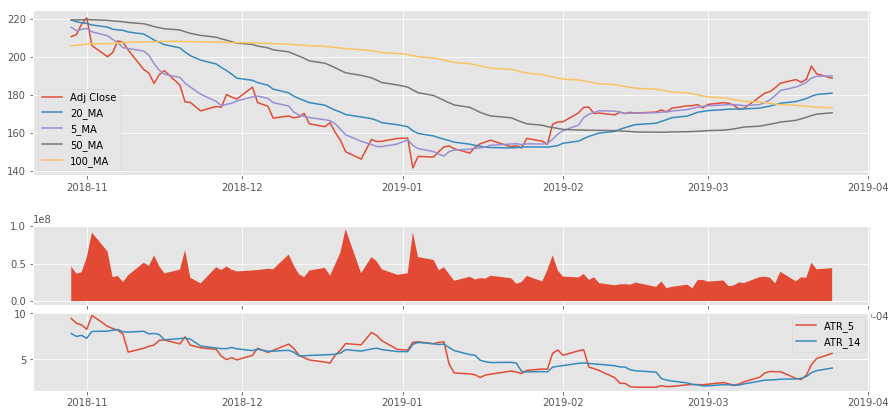

In [24]:
ax1 = plt.subplot2grid((9,1), loc=(0,0), rowspan=4, colspan=(1))
ax2 = plt.subplot2grid((9,1), loc=(5,0), rowspan=2, colspan=(1), sharex=ax1)
ax3 = plt.subplot2grid((9,1), loc=(7,0), rowspan=2, colspan=(1), sharex=ax1)
start = -100 #1 trading year


ax1.plot(aapl_df.index[start:], aapl_df['Adj Close'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['20_MA'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['5_MA'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['50_MA'][start:])
ax1.plot(aapl_df.index[start:], aapl_df['100_MA'][start:])
ax2.fill_between(aapl_df.index[start:], aapl_df['Volume'][start:], 0)
#ax2.ylabel('Volume')
ax3.plot(aapl_df.index[start:], aapl_df['ATR_5'][start:])
ax3.plot(aapl_df.index[start:], aapl_df['ATR_14'][start:])
ax1.legend()
ax3.legend()
plt.show()

# Analyzing trends and which metrics to pick

In the above graph, we have mapped out the adjusted closing price of Apple stock, 4 variations of of the rolling moving average (5 day, 20 day, 50 day, and 100 day), volume of stock being traded, and finally the average true range (ATR) with a window of 5 and 14 days.

From the top graph, we see that the 100 day moving average finds the larger trend over time, but lags behind quite a bit in the volative ups and downs of the stock price. The 50 day seems to be similar to the 100 day one, but lags behind a bit less. The 20 day MA gets close to the close price, but seems to be lagging behind the actual price trends as well. The 5 day MA gets the closest to the actual trend of the stock, but it's also the most volatile of the 4. 

Another thing we see is that volume seems to correlate with volatility of the stock. Although not perfect, increases in volume seem to mark changes in stock price, whether that's up or down.
Finally, we analyze the average true range. It also seems to have a slight trend associated with price of stock, although not as consistently as volume. The 5 day window seems to correlate the most with upticks in volume, while the 14 day windows goes towards the overall trend.

# Comparing SMA to EMA

SMA and EMA are very similar, but their calculations start to matter more when we take longer periods into account as EMA are more responsive to recent days in their calculations

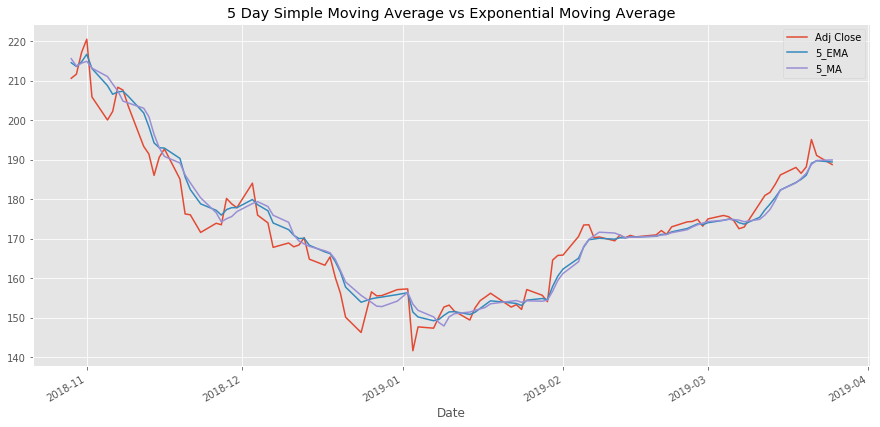

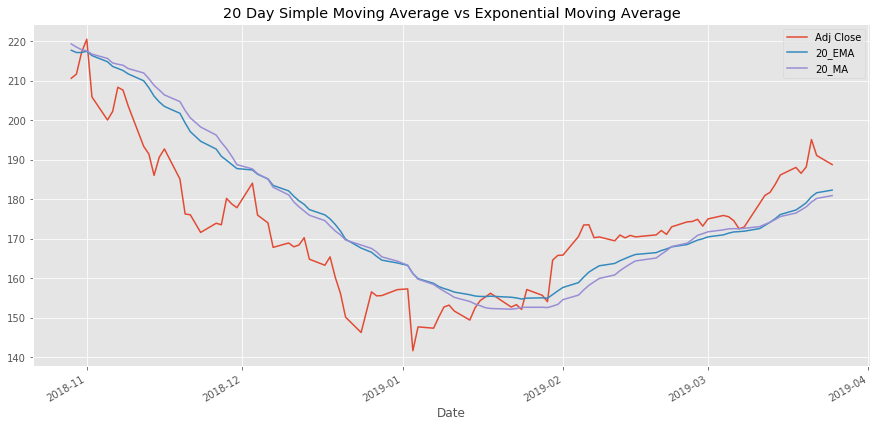

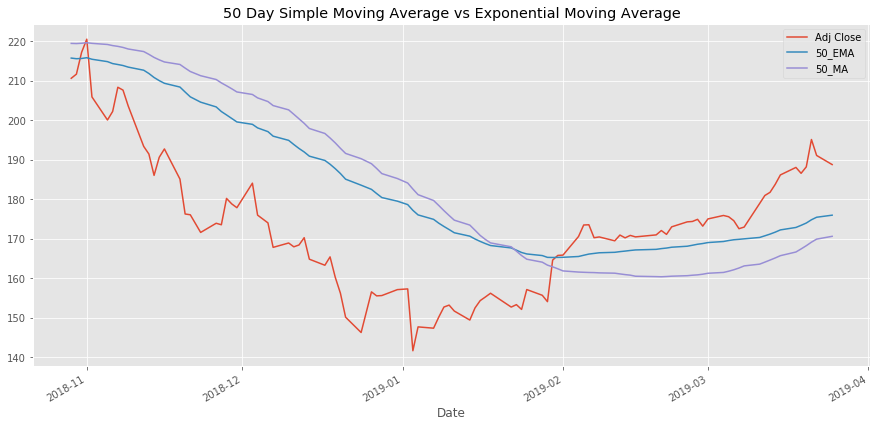

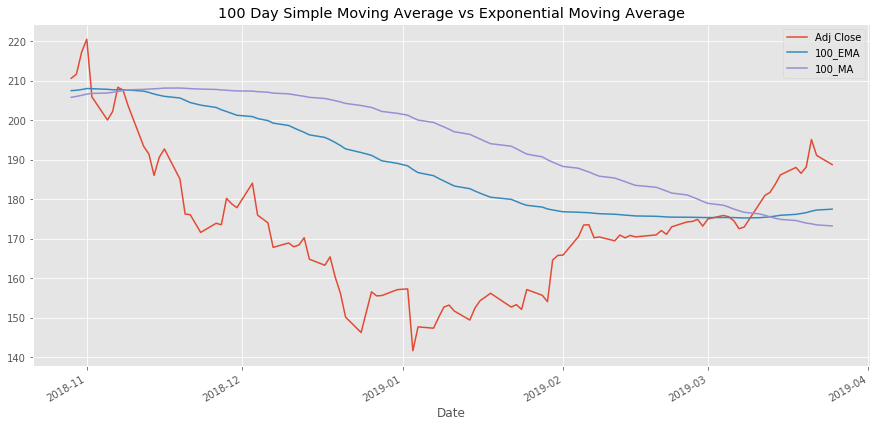

In [25]:
plot_obj = aapl_df[['Adj Close', '5_EMA', '5_MA']][-100:]
plot_obj.plot()
plt.title("5 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

plot_obj = aapl_df[['Adj Close', '20_EMA', '20_MA']][-100:]
plot_obj.plot()
plt.title("20 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

plot_obj = aapl_df[['Adj Close', '50_EMA', '50_MA']][-100:]
plot_obj.plot()
plt.title("50 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

plot_obj = aapl_df[['Adj Close', '100_EMA', '100_MA']][-100:]
plot_obj.plot()
plt.title("100 Day Simple Moving Average vs Exponential Moving Average")
plt.show()

Comparing the EMA to SMA, we see that these measures are very similar. On smaller time scales, such as the 5 day one, we see that there is little to no difference between the two. But when we start increasing the scale, we start to see that the EMA becomes more response to recent price trends. Due to the nature of EMA's weighting recent days in their window more strongly, they are a better measure once the window becomes large  enough. For now, we see that the EMA has better potential for our purposes as a single trend line isn't too useful by itself. It's when we start combining low and high frequency (relative to this context) trend lines can we identify deeper patterns. The problem now with EMAs is that they dont take intra day price shifts into account. All they really look at are close-close price trends.

The Kaufman Adaptive Moving Average (KAMA) is a very complex trend indicator and is one of the more recent and popular ones to be developed in the list. It takes the concept of exponential moving averages and adds in the concept of volatility to further distinguish it as a trend indicator.

In [26]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator - As suggested by Perry Kaufman, we will use KAMA(10,2,30) as the constants
        * 10 is the number of periods for the Efficiency Ratio (ER).
        * 2 is the number of periods for the fastest EMA constant.
        * 30 is the number of periods for the slowest EMA constant.'''    
    ''' accepts pandas dataframe of prices '''
    """ We need the Efficiency Ratio (ER) and Smoothing Constant (SC) to get KAMA.
        ER = Change/Volatility
        
        Change = ABS(Close - Close (10 periods ago))
        Volatility = Sum10(ABS(Close - Prior Close))
        Volatility is the sum of the absolute value of the last ten price changes (Close - Prior Close).
        
        SC = [ER x (fastest SC - slowest SC) + slowest SC]2
        SC = [ER x (2/(2+1) - 2/(30+1)) + 2/(30+1)]2"""

    absDiffx = abs(price.diff()) 

    ER_change = abs( price - price.shift(n) )
    ER_volatility = absDiffx.rolling(10).sum()
    ER = ER_change / ER_volatility

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

short_power = 2
long_power = 5
aapl_df['KAMA_10_{}_30'.format(short_power)] = KAMA(aapl_df['Adj Close'])
aapl_df['KAMA_10_{}_30'.format(long_power)] = KAMA(aapl_df['Adj Close'], pow1=5)

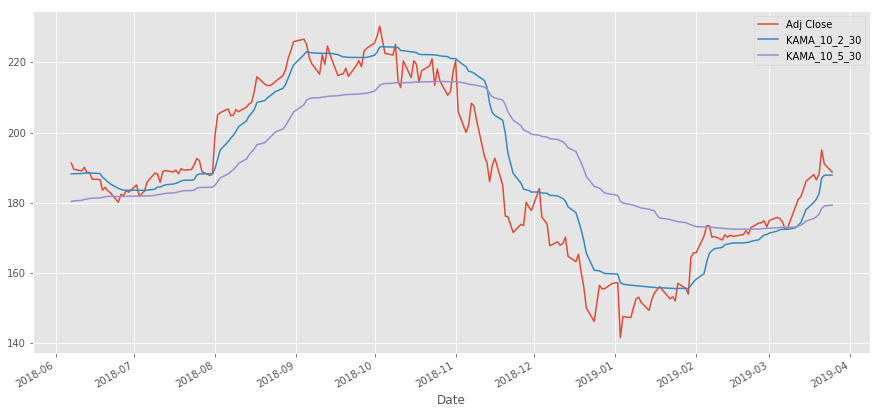

In [27]:
aapl_df[['Adj Close', 'KAMA_10_2_30', 'KAMA_10_5_30']].iloc[-200:].plot()
plt.show()

In [28]:
def kama_signals(df):
    short_shift = df['KAMA_10_2_30'].shift()
    long_shift = df['KAMA_10_5_30'].shift()
    df['KAMA_sell'] = np.where(((short_shift > long_shift) & (df['KAMA_10_2_30']<=df['KAMA_10_5_30'])), 1, 0)
    df['KAMA_buy'] = np.where(((short_shift < long_shift) & (df['KAMA_10_2_30']>=df['KAMA_10_5_30'])), 1, 0)
    
kama_signals(aapl_df)

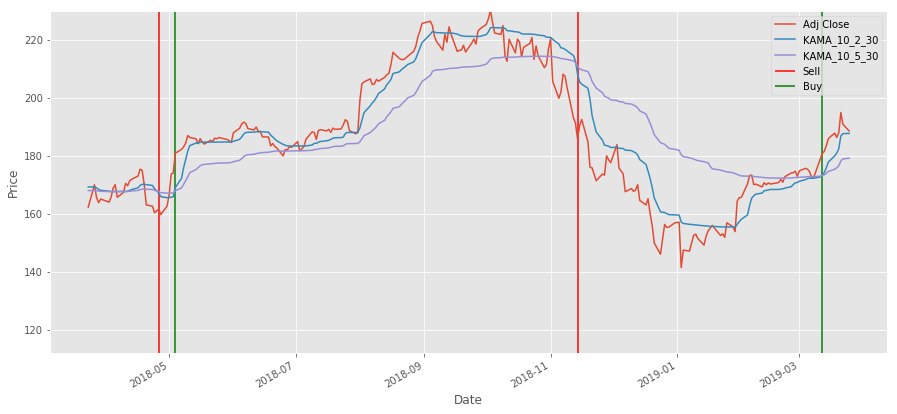

In [29]:
start = -252
aapl_df.loc[:,['Adj Close', 'KAMA_10_2_30', 'KAMA_10_5_30']][start:].plot()

plt.vlines(aapl_df.iloc[start:].loc[aapl_df['KAMA_sell']==1].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Sell',
           colors='r')

plt.vlines(aapl_df.iloc[start:].loc[aapl_df['KAMA_buy']==1].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Buy',
           colors='g')

plt.ylabel("Price")
plt.legend()
plt.ylim(aapl_df['Adj Close'].min() ,aapl_df['Adj Close'].max())
plt.show()

Judging from the above graph, we see KAMA_10_2_30 cross KAMA_10_5_30 a few times around key points of the stock movement. For convenience sake, I shall refer to KAMA_10_2_30 as small_KAMA and KAMA_10_5_30 as large_KAMA. Whenever the small_KAMA cross above the the large_KAMA from below, this usually indicates a bullish moveement. When the small_KAMA cross below the large_KAMA, it usually indicates a bearish signal. Do note that these signals lag behind (come after) the actual time when the price trend starts to go down so we have to consider that into our strategy. Judging by the signals created, we missed quite a few points of entry and exit, even though our signals are around points where the short KAMA line crosses the long KAMA line. 

This tool is a great chart reading skill too. Whenever KAMA increases, then the stock price increases as well and is very responsive to recent stock prices. With this, we can see how increases in KAMA usually follow a period of stabilized KAMA then it goes down. Generally, this pattern continues on for a stock unless outside factors lead to drastic changes in the stock performance such as sentiment changes and changes to the law. 

There is potential to use this as a trade signal.

# Oscillators - technical signals that follow the up and down flow of stocks to find out if a stock is overbought or oversold

### Relative Strength Index (RSI)

RSI is used to measure the change and speed of price fluctuations. It provides an idea as to the recent performance of a stock in the amrket. The scale of this is from 0 to 100. Usually, if the RSI of a stock is above 70, then it's overbought and is likely due to drop in price. If the RSI is below 30, then a stock is oversold and will likely increase in price soon. RSI is calculated from the following $$ RSI = 100 - 100/ (1 + RS) $$

RS in this case is the average gain from a specified time period. 

In [30]:
def set_RSI(df, window=14):
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=window)
    
    
def plot_RSI(df):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df.RSI, label='RSI')
    ax.fill_between(df.index, y1=25, y2=80, color = 'lightcoral', alpha='0.3')
    ax.set_xlabel('Date')
    ax.set_ylabel('RSI')
    plt.show()

In [31]:
set_RSI(aapl_df)
aapl_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date,High-Low,|H-Cp|,|L-Cp|,...,100_MA,5_EMA,20_EMA,50_EMA,100_EMA,KAMA_10_2_30,KAMA_10_5_30,KAMA_sell,KAMA_buy,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-19,188.350006,188.990005,185.919998,186.529999,186.529999,31646400,737137.0,3.070007,0.970001,2.100006,...,174.245267,184.982901,178.119887,173.350758,176.339997,181.105539,176.028832,0,0,72.947896
2019-03-20,186.229996,189.490005,184.729996,188.160004,188.160004,31035200,737138.0,4.760009,2.960006,1.800003,...,173.916790,186.041935,179.076088,173.931513,176.574057,182.611685,176.739238,0,0,74.758448
2019-03-21,190.020004,196.330002,189.809998,195.089996,195.089996,51034200,737139.0,6.520004,8.169998,1.649994,...,173.733422,189.057955,180.601222,174.761258,176.940709,187.051474,178.412951,0,0,80.679061
2019-03-22,195.339996,197.690002,190.779999,191.050003,191.050003,42407700,737140.0,6.910003,2.600006,4.309997,...,173.462918,189.721971,181.596344,175.400032,177.220101,187.820642,179.090282,0,0,70.323292
2019-03-25,191.509995,191.979996,186.600006,188.740005,188.740005,43845300,737143.0,5.379990,0.929993,4.449997,...,173.204044,189.394649,182.276693,175.923168,177.448218,187.901571,179.363177,0,0,65.172197


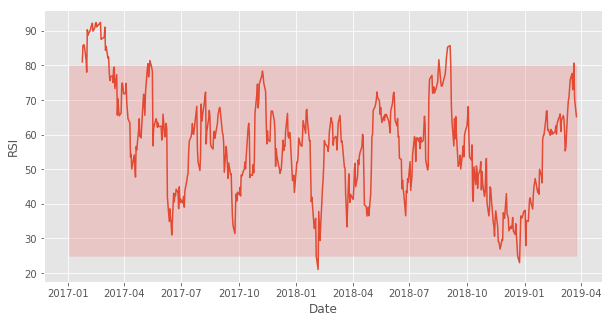

In [32]:
plot_RSI(aapl_df)

In [33]:
def rsi_signals(df):
    df['RSI_entry'] = np.where(df['RSI']<25, 1, 0)
    df['RSI_exit'] = np.where(df['RSI']>80, 1, 0)
    
rsi_signals(aapl_df)

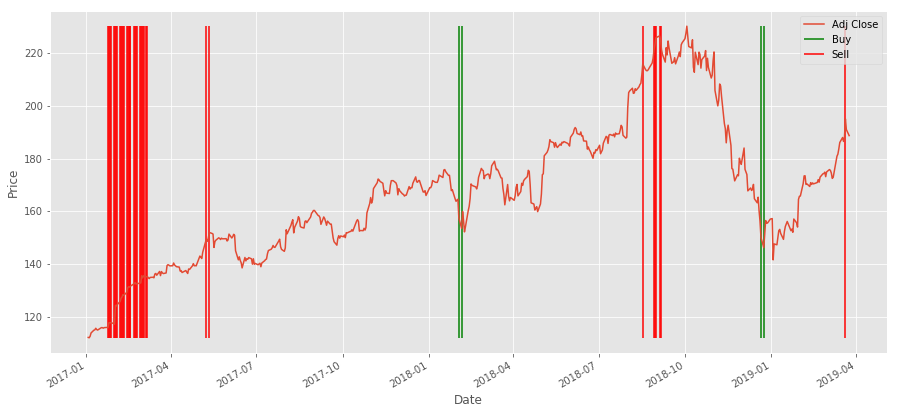

In [34]:
start = 0
aapl_df.loc[:,'Adj Close'].iloc[start:].plot()

plt.vlines(aapl_df.loc[aapl_df['RSI_entry']==1].iloc[start:].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Buy',
           colors='g')

plt.vlines(aapl_df.loc[aapl_df['RSI_exit']==1].iloc[start:].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Sell',
           colors='r')
plt.ylabel("Price")
#plt.ylim(120,230)
plt.legend()
plt.show()

RSI seems to be a very good indicator for buying and selling without overpopulating with signals that might be noise as seen from the other signals before. We do see that there are some early sell off signals in this trend but that's likely due to a hindsight bias. This provides a relatively safe signal with which to buy and sell stocks from. There are maybe a few periods where one could capitalize on, but that would require the integration of other technical signals to further fine tune thefeatures for the model.

# Volume - Indicators tracking volume at an absoulte or relative level

This is a straightforward technical indicator but a very important one. Volume and price are very closely related in that it indicates momentum about a stocks price. Some common indicators for this is the regular volume and on-balance volume.

On balance volume is the flow of volume in relation to total volume. Increases in OBV usually mean icnreases in stock price and vice versa. The actual value of OBV does not matter as it's a relative value in accordance to the start period we give it. What matters is the slope of the line as OBV changes over time. OBV is calculated as follows: <img src="https://www.investopedia.com/thmb/qyg3KOLEiR_soihtw8zxexYkZqg=/1280x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/latex_857b49bb29298504668777b5476605c5-5c4f426d46e0fb000167c88a.jpg" style="width: 500px;">


This value shows the realtionship of volume change in relation to price. Usually, large investment firms will buy large amounts of volume, even if price stays relatively the same. Eventually, the price will inevitably rise due to volume increases thus leading them to sell the stock and causing retail consumers/investors to buy the stock. The main idea for investment firms is to increase volume so that other small investors join in and sell at an opportune moment to reap the profits.

Now the main thing that's important about OBV is not its actual value, but rather the components that form it. The important pieces of information to note with OBV is whether there was more buy or sell volume and the overall trend of whether there are more uptrends or downtrends. If there is a general uptrend in the volume, then there's a good chance that price will also increase which is a good indicator for an investor to buy stocks. If there is a downtrend ocurring, then there is a good chance that it's a  good time to sell or even short the stock. Due to the close relationship between price and volume, this has the potential to be a good indicator. 

In [35]:
def set_OBV(df):
    df['OBV'] = ta.OBV(df['Adj Close'].values, df['Volume'].astype(np.float64).values)
    df['Up_down_signal'] = np.where(df['Adj Close'] > df['Adj Close'].shift(), 1, -1)
    df['Up_down_volume'] = df['Volume'] * df['Up_down_signal']
    
set_OBV(aapl_df)

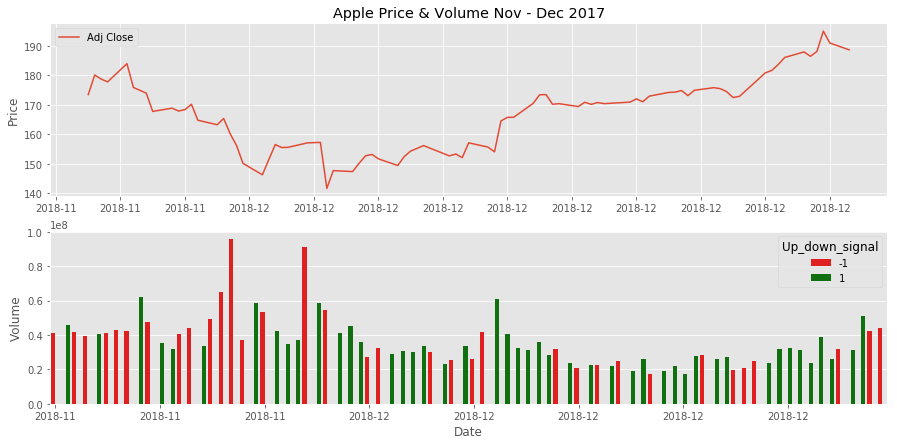

In [36]:
start=-80
obv_plot = aapl_df.iloc[start:].loc[:,['Adj Close', 'Volume', 'Up_down_signal']]
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(obv_plot.index, obv_plot['Adj Close'])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.set_xticklabels([pd.to_datetime(tm, unit='ms').strftime('%Y-%m') for tm in obv_plot.index])
ax1.set_ylabel('Price')
ax1.legend()
ax1.set_title('Apple Price & Volume Nov - Dec 2017')
sns.barplot(x=pd.to_datetime(obv_plot.index), 
            y=obv_plot['Volume'], 
            hue=obv_plot['Up_down_signal'],
            ax=ax2,
            palette={-1:'r', 1:'g'}
           )
ax2.set_xticklabels([pd.to_datetime(tm, unit='ms').strftime('%Y-%m') for tm in obv_plot.index])
ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show()

The two graphs above are a lot to unpack, but they do convey a great deal of information. The top plot shows the close price of Apple in relation to signals set up to show whether the previous close price was higher or lower than the current price. If the current price was lower, then a red vertical line was plotted and if the close price was higher, then a green vertical line was plotted. What this information conveys is that for that specific day, was there more sell volume or buy volume. This indication can be used in a moving window to see if there were more days of sell volume, indicating that the price is going towards a downtrend. Conversely, if there's more buy volume, a moving window would show more positive signals, thus showing that the price is going towards an uptrend. Usually this information is used as a charting skill, but we can try to make this signal algorithmically when we backtest.

# Volatlity based strategy

Volatility can be a useful measure by which we can enter or exit a trade. A general trend in stocks is periods of low volatility following periods of high volatility and vice versa. Using this, we can maybe form a strategy that runs a trade if the price is above or below a certain level of volatility based on previous prices.

By using ATR, we can set up signals to sell our stock when it starts to trend downwards based on volatility or buy when the volatility points to an uptrend from previous data.

In [37]:
def ATR_signal(df):
    df['ATR_entry'] = np.where(df['Adj Close'] > df['Adj Close'].shift()+df['ATR_14']*1.5, 1, 0)
    df['ATR_exit'] = np.where(df['Adj Close'] < df['Adj Close'].shift()-df['ATR_14']*1.5, 1, 0)
ATR_signal(aapl_df)

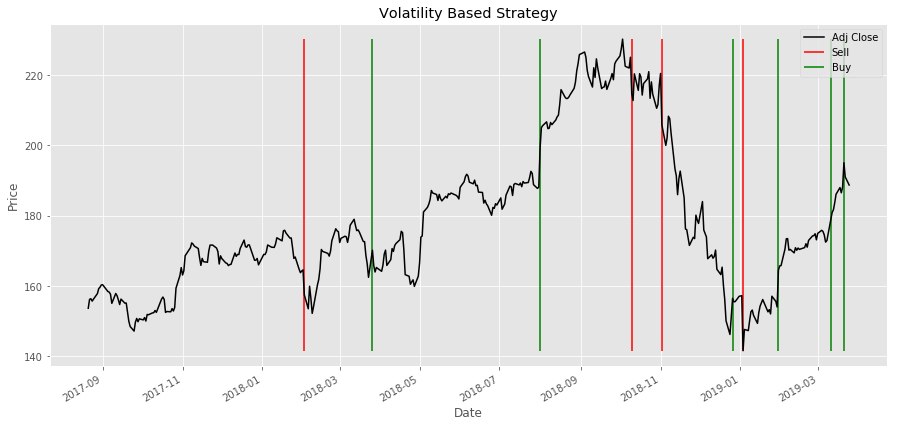

In [38]:
start = -400
atr_plot = aapl_df.iloc[start:].loc[:,['Adj Close', 'ATR_exit', 'ATR_entry']]

atr_plot['Adj Close'].plot(color='black')
plt.ylabel("Price")
plt.vlines(atr_plot[atr_plot['ATR_exit']==1].index, 
           ymin=atr_plot['Adj Close'].min(), 
           ymax=atr_plot['Adj Close'].max(), 
           label='Sell',
           colors='r')

plt.vlines(atr_plot[atr_plot['ATR_entry']==1].index, 
           ymin=atr_plot['Adj Close'].min(), 
           ymax=atr_plot['Adj Close'].max(), 
           label='Buy',
           colors='g')
plt.legend()
plt.title("Volatility Based Strategy")
plt.show()

The volatility based strategy produces some fairly good signals. The bug drawback for it is that it's very vulnerable to sharp changes in price movements and makes trades based on these sharp changes. This can be detrimental at times because sudden movements in price can cause one to quickly buy and sell stock in a very short period, resulting in inadvisable trades. But so far it isn't too detrimental from looking at the graph.

# Checking for stationary in data before  we start modeling

Other than visual inspection of our data as well as looking at descriptive statistics for our stocks to determine stationarity, we can rely on more stringent statistical tests to evaluate the degree to which our data is likely to be stationary or not.

Based on previous inspection of the Apple stock, we can clearly see that there is a trend to the data. Seasonality does not seem be as apparent at the monthly or weekly level.

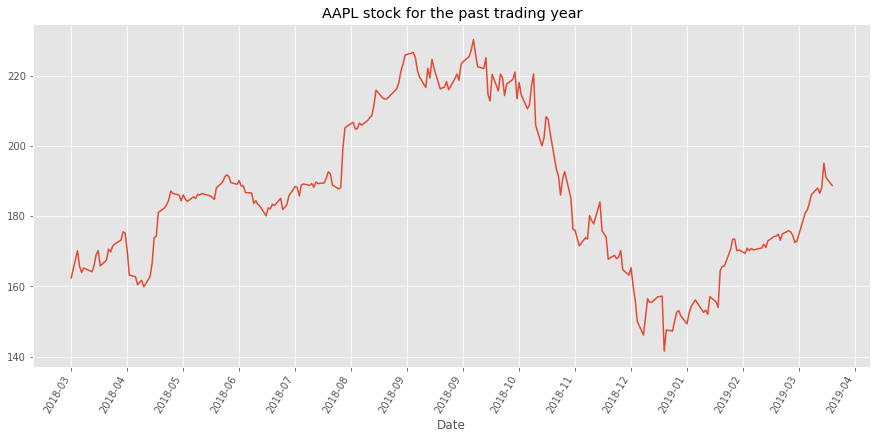

In [39]:
fig, ax = plt.subplots()
aapl_df['Adj Close'][-252:].plot()
plt.title("AAPL stock for the past trading year")
ax.xaxis.set_major_locator(ticker.MultipleLocator(27))
plt.xticks(rotation=60)
plt.show()

Visual inspection shows us that the regular stock close price is not stationary. There doen't seem to be any seasonality but there does seem to be a trend.

In [40]:
# Running statistical tests to check for stationarity
def check_stationarity(df, item):
    X = df[str(item)]
    result = adfuller(X)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))
    return
        
check_stationarity(aapl_df.loc['2012':'2017-12-31'], 'Adj Close')

ADF Statistic: -1.924
p-value: 0.321
Critical Values:
	5%: -2.874
	1%: -3.458
	10%: -2.573


The above result shows that our Apple stock close price is likely to not be stationary as the p value for our result was above .05, therefor we cannot reject the null hypothesis that our data is not stationary.

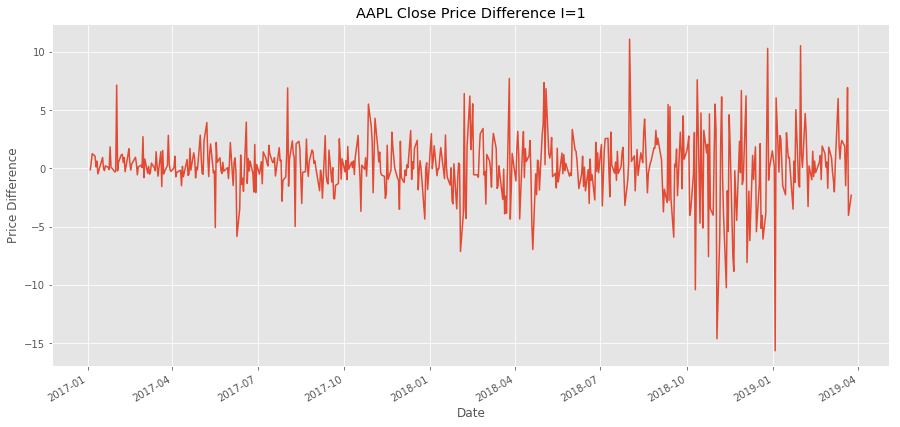

In [41]:
aapl_df['Diff_1'] = aapl_df['Adj Close'] - aapl_df['Adj Close'].shift(1)
aapl_df['Diff_1'].plot()
plt.ylabel("Price Difference")
plt.title("AAPL Close Price Difference I=1")
plt.show()

In [43]:
check_stationarity(aapl_df[1:], 'Diff_1')

# The statistic says it's stationary, but the varaince is not constant which can prove to be problematic

ADF Statistic: -7.760
p-value: 0.000
Critical Values:
	5%: -2.867
	1%: -3.442
	10%: -2.570


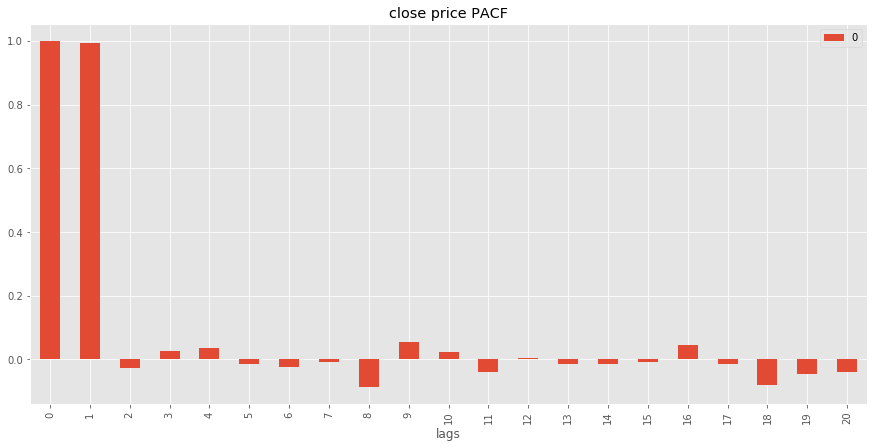

In [53]:
def plot_acf(df, name):
    _pacf = pd.DataFrame(pacf(df, nlags=20))
    _pacf.plot(kind='bar')
    plt.title("{} PACF".format(name))
    plt.xlabel("lags")
    plt.show()

plot_acf(aapl_df['Adj Close'], 'close price')


# Using log of the closing price to make data stationary

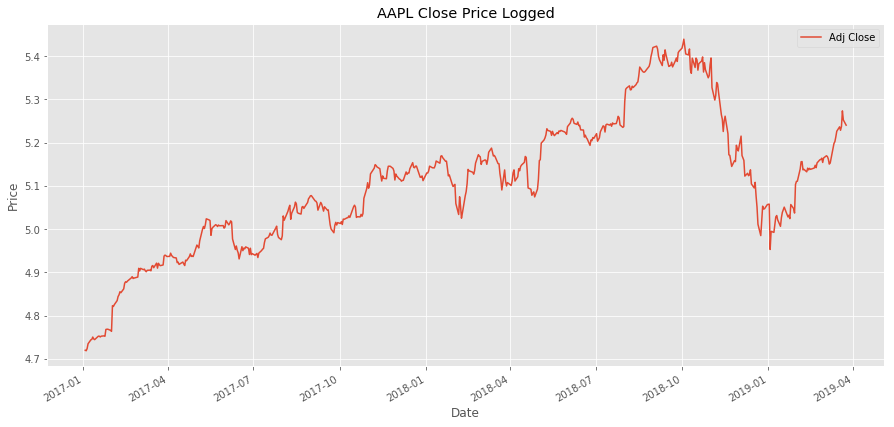

In [54]:
aapl_log_price = pd.DataFrame(np.log(aapl_df['Adj Close']), index=aapl_df.index)
aapl_log_price.plot()
plt.ylabel('Price')
plt.title("AAPL Close Price Logged")
plt.show()

In [55]:
aapl_log_price['diff'] = aapl_log_price - aapl_log_price.shift()

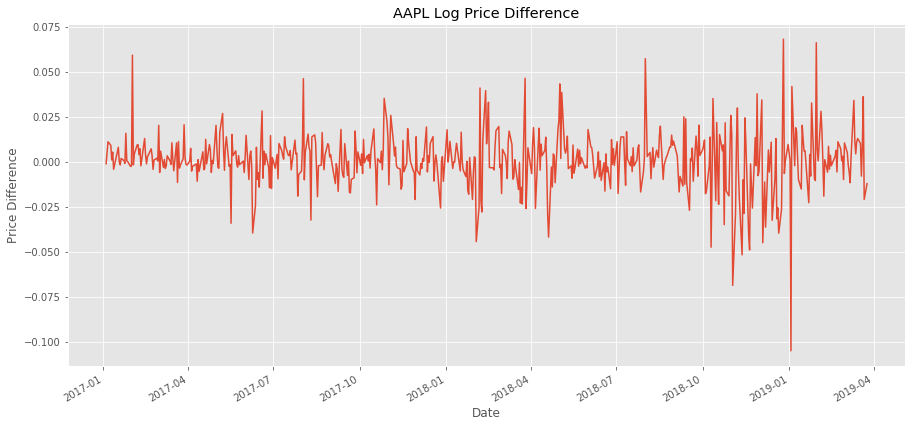

In [56]:
aapl_log_price['diff'].plot()
plt.title("AAPL Log Price Difference")
plt.ylabel("Price Difference")
plt.show()

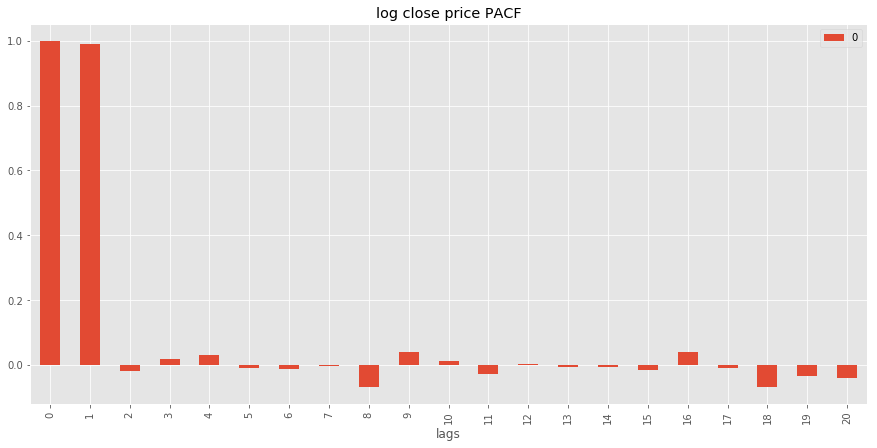

In [59]:
plot_acf(aapl_log_price['Adj Close'], 'log close price')

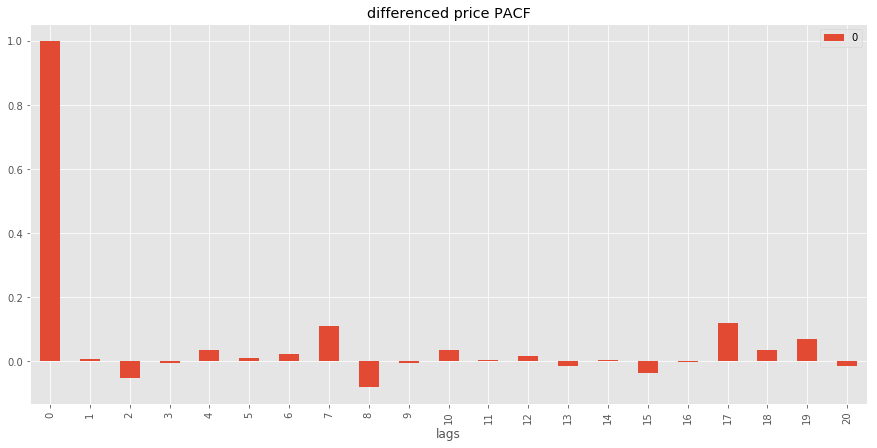

In [61]:
plot_acf(aapl_log_price['diff'][1:], 'differenced price')

### Looking at the data, the differenced portion is mostly stationary except for one portion in 2001, so we can exclude that by taking data from a window

In [46]:
check_stationarity(aapl_log_price.dropna(), 'diff')

ADF Statistic: -23.415
p-value: 0.000
Critical Values:
	10%: -2.570
	1%: -3.442
	5%: -2.867


The Dukey-Fuller test confirms the assumptions from the graph that the data does seem to be stationary since the statistic value is small and the p value is significant. 

# Modeling price

Autoregressive models have been developed to capture time series data that is stationary (AR), has a trend (ARIMA), and has a seasonal component as well (SARIMA). These models try to model the conditional mean of a stochastic process. 

Using ARIMA, we can see if we can predict price direction and set up buy and sell signals properly for the given period. 

In [80]:
train = aapl_df.iloc[:-100].loc[:,'Adj Close'].rolling(window=5).mean()
train_log = train.map(np.log)
test = aapl_df.iloc[-100:].loc[:, 'Adj Close'].rolling(window=5).mean()
test_log = test.map(np.log)

print("Train samples:", len(train))
print("Test samples:", len(test))

Train samples: 459
Test samples: 100


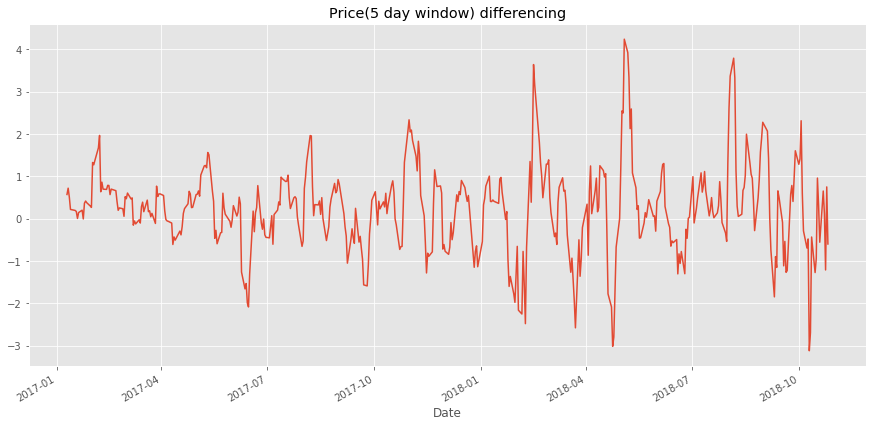

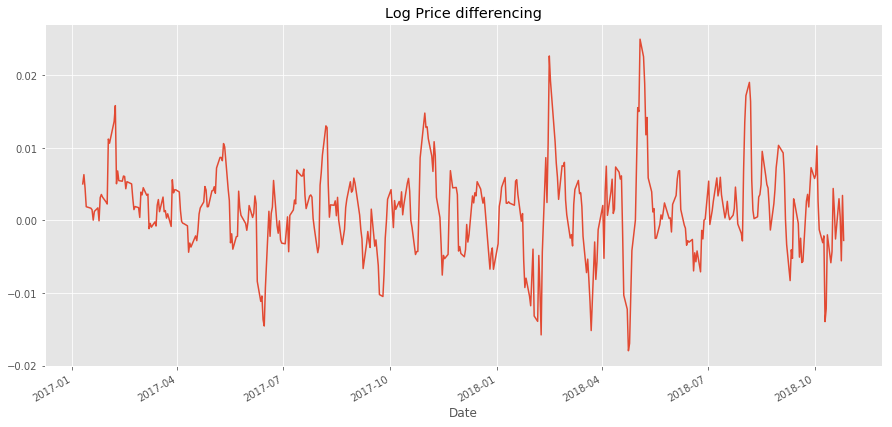

In [81]:
diff = train - train.shift()
diff.plot()
plt.title('Price(5 day window) differencing')
plt.show()

diff = train_log - train_log.shift()
diff.plot()
plt.title('Log Price differencing')
plt.show()

In [82]:
arima = auto_arima(train[4:], #skip na values
                   start_p=2, 
                   max_p=4, 
                   start_q=2, 
                   max_q=4, 
                   seasonal=False, # stock data did not seem to be seasonal from bisual inspection
                   m=1,
                   D=1,
                   information_criterion='bic',
                   max_iter=150,
                   solver='cg',
                   suppress_warnings=True
                  )
model_fit = arima.fit(train[4:])
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  454
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -346.749
Method:                       css-mle   S.D. of innovations              0.513
Date:                Sun, 31 Mar 2019   AIC                            709.497
Time:                        19:52:26   BIC                            742.442
Sample:                             1   HQIC                           722.477
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2236      0.099      2.261      0.024       0.030       0.417
ar.L1.D.y      1.3969      0.045     31.116      0.000       1.309       1.485
ar.L2.D.y     -1.2459      0.070    -17.907      0.0

In [83]:
pred = model_fit.predict(n_periods=len(test))
predictions = pd.Series(pred, index=test.index)

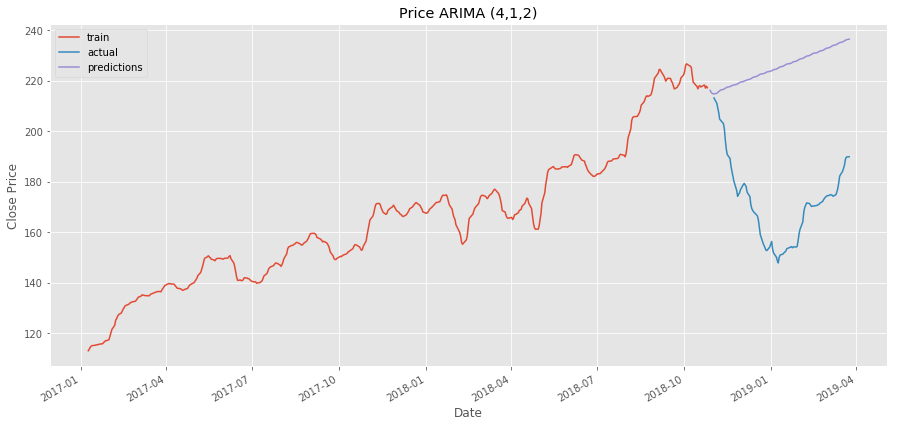

In [84]:
train.plot(label='train')
test.plot(label='actual')
predictions.plot(label='predictions')
plt.title("Price ARIMA (4,1,2)")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [85]:
arima = auto_arima(train_log[4:], 
                   start_p=2, 
                   max_p=4, 
                   start_q=2, 
                   max_q=4, 
                   seasonal=False, # stock data did not seem to be seasonal from bisual inspection
                   m=1,
                   D=1,
                   information_criterion='bic',
                   max_iter=150,
                   solver='cg',
                   suppress_warnings=True
                  )
model_fit = arima.fit(train_log[4:])

print(model_fit.summary())

C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 4); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  454
Model:                 ARIMA(1, 1, 4)   Log Likelihood                2044.189
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 31 Mar 2019   AIC                          -4074.379
Time:                        19:55:24   BIC                          -4045.552
Sample:                             1   HQIC                         -4063.021
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.411      0.016       0.000       0.003
ar.L1.D.y     -0.0142      0.052     -0.271      0.786      -0.116       0.088
ma.L1.D.y      0.9769      0.028     35.443      0.0

In [86]:
pred = model_fit.predict(n_periods=len(test_log))
predictions = pd.Series(pred, index=test_log.index)
predictions = predictions.map(np.exp)

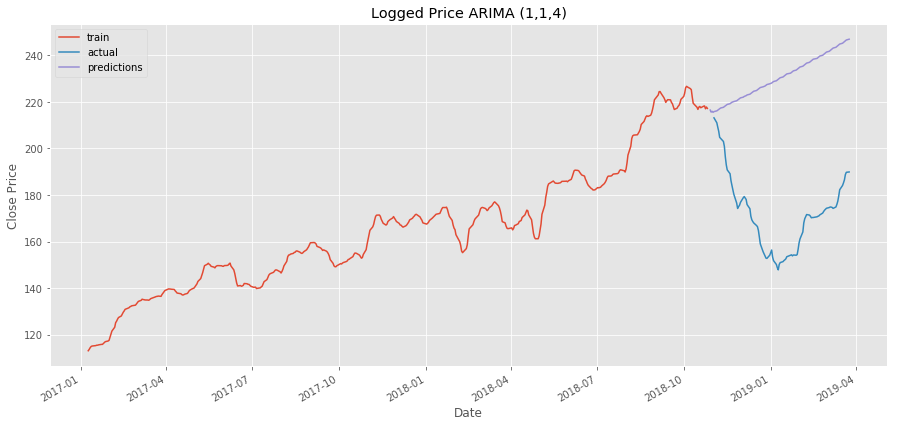

In [89]:
train.plot(label='train')
test.plot(label='actual')
predictions.plot(label='predictions')
plt.title("Logged Price ARIMA (1,1,4)")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Judging by the ARIMA model, we see that it just takes the previous datas overall trend and uses that to predict the future. It doesn't take into account multiple factors such as sentiment and law changes. The above model returns the same results, but with with a slightly better accuracy of the previous trend, but it's still not a good method for future predictions. 

# LSTM

A form of recurrent neural networks that has a memory aspect to it that makes it great for analyzing sequential data. The input for LSTM is very specific in that it requires the input to be within the range of 0 to 1 for its activation function to work properly, $tanh(X)$. As opposed ot using the standard scalar, which can leak information to the model by scaling data to how relative it is from the mean, we will use min max scalar to create our normalized values. This way our values range from 0 to 1 and can fit perfectly with our activation function. 

We will try to use LSTM to predict 60 days of the latest stock data absed on previous stock data. We will be using a much larger amount of data to better train the neural network.

In [55]:
# Quandl doesn't have access to mid 2018 data and onwards
start = '2015-03-24'
end = '2019-03-24'
new_data = yf.download('AAPL', start, end)['Adj Close']
#creating train and test sets
dataset = new_data.values

train = dataset[:947].reshape(-1,1)
test = dataset[947:].reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)

[*********************100%***********************]  1 of 1 downloaded


In [56]:
X_train, Y_train = [], []

# create array of the previous 60 timestamps
# What this is essentially doing is creating 60 timestamps step wise with each row being lagged by one trading day
# This creates the features necessary for a short term memory of the stock price movement
for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-60:i, 0])
    Y_train.append(scaled_train[i, 0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshaping our training data to a 3D array that LSTM can read. 
# The format of the input shape for LSTM is (batch values(total rows in consideration), time_steps per record, input dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

## LST netowrk with 2 LSTM layers followed by dropout layers and a final dense layer

In [57]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(.2))

model.add(Flatten())
# Give one output
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3001      
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=1)


Epoch 1/10
887/887 [==============================] - 168s 189ms/step - loss: 0.0094
Epoch 2/10
887/887 [==============================] - 165s 186ms/step - loss: 0.0049
Epoch 3/10
887/887 [==============================] - 165s 186ms/step - loss: 0.0031
Epoch 4/10
887/887 [==============================] - 165s 186ms/step - loss: 0.0027
Epoch 5/10
887/887 [==============================] - 166s 187ms/step - loss: 0.0024
Epoch 6/10
887/887 [==============================] - 165s 186ms/step - loss: 0.0025
Epoch 7/10
887/887 [==============================] - 165s 186ms/step - loss: 0.0028
Epoch 8/10
887/887 [==============================] - 164s 185ms/step - loss: 0.0020s - - ETA: 2s
Epoch 9/10
887/887 [==============================] - 168s 189ms/step - loss: 0.0016
Epoch 10/10
887/887 [==============================] - 165s 187ms/step - loss: 0.0018


In [68]:
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)

inputs = scaler.transform(inputs)

In [69]:
# Making rows of data points that contain 60 days worth of data. Each row is shifted by one day, allowing the LSTM model to have
# a snese of memory
X_test = []
for i in range(60, 120):
    X_test.append(inputs[i-60:i])
X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [70]:
pred = model.predict(X_test)
pred_reverse_transform = scaler.inverse_transform(pred)

In [71]:
pred = model.predict(X_test).reshape(-1,1)
pred_reverse_transform = scaler.inverse_transform(pred)

pred_df = pd.DataFrame(pred_reverse_transform, index=new_data.iloc[947:].index, columns=['Adj Close'])

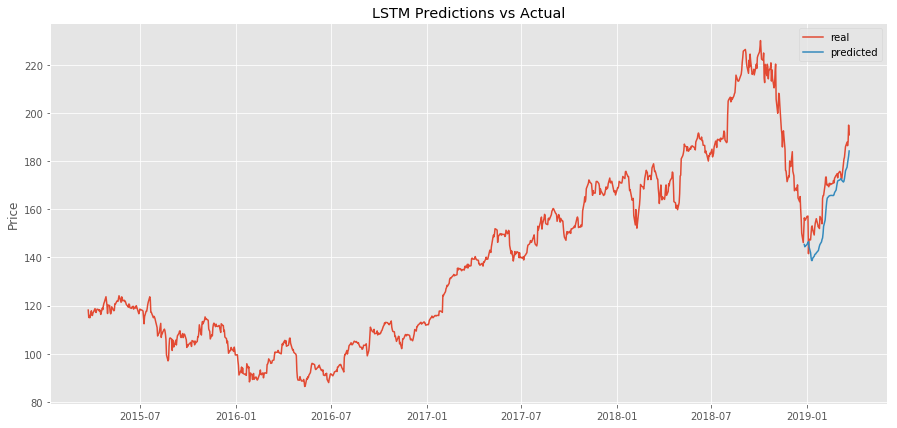

MSE for 60 day period: 85.55894235891884


In [72]:
fig, ax = plt.subplots()
plt.plot(new_data.index, new_data, label='real')
plt.plot(pred_df.index, pred_df, label='predicted')
plt.ylabel("Price")
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()
error = mse(new_data.iloc[947:], pred_df)
print("MSE for 60 day period:", error)

In [73]:
# to fix appedning issues between dataframe and series due to column naming not aligning
aapl_df_close = pd.DataFrame(new_data[:947], index=new_data.iloc[:947].index, columns=['Adj Close'])

prior_with_pred_df = pd.concat([aapl_df_close, pred_df], axis=0)
display(prior_with_pred_df.head())
prior_with_pred_df.tail()

,Adj Close
Date,
2015-03-24,118.113708
2015-03-25,115.027771
2015-03-26,115.829559
2015-03-27,114.906578
2015-03-30,117.815361


,Adj Close
Date,
2019-03-18,177.600983
2019-03-19,179.334656
2019-03-20,180.819672
2019-03-21,182.276978
2019-03-22,184.327118


In [74]:
set_RSI(prior_with_pred_df)
rsi_signals(prior_with_pred_df)

set_RSI(aapl_df_close)
rsi_signals(aapl_df_close)

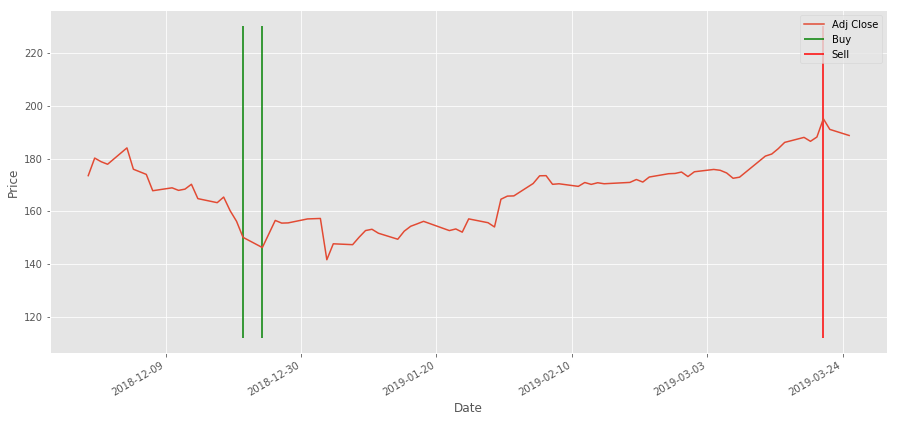

In [75]:
start=-80
fig, ax = plt.subplots()
aapl_df.iloc[start:].loc[:,'Adj Close'].plot(ax=ax)

ax.vlines(aapl_df.iloc[start:].loc[aapl_df['RSI_entry']==1].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Buy',
           colors='g')

ax.vlines(aapl_df.iloc[start:].loc[aapl_df['RSI_exit']==1].index, 
           ymin=aapl_df['Adj Close'].min(), 
           ymax=aapl_df['Adj Close'].max(), 
           label='Sell',
           colors='r')
plt.ylabel("Price")
ax.xaxis.set_major_locator(ticker.MultipleLocator(21))
#plt.ylim(120,230)
plt.legend()
plt.show()

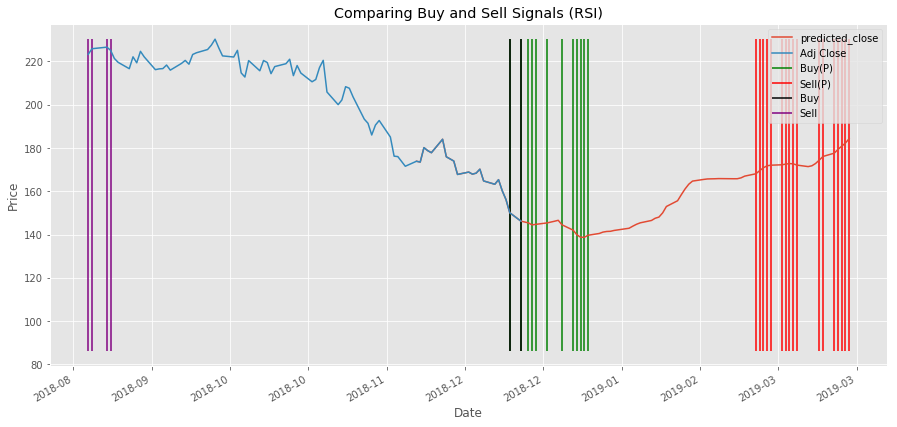

In [76]:
start=-80
fig, ax = plt.subplots()
prior_with_pred_df.iloc[start:].loc[:,'Adj Close'].plot(ax=ax, label='predicted_close')

ax.vlines(prior_with_pred_df.iloc[start:].loc[prior_with_pred_df['RSI_entry']==1].index, 
           ymin=prior_with_pred_df['Adj Close'].min(), 
           ymax=prior_with_pred_df['Adj Close'].max(), 
           label='Buy(P)',
           colors='g')

ax.vlines(prior_with_pred_df.iloc[start:].loc[prior_with_pred_df['RSI_exit']==1].index, 
           ymin=prior_with_pred_df['Adj Close'].min(), 
           ymax=prior_with_pred_df['Adj Close'].max(), 
           label='Sell(P)',
           colors='r')

aapl_df_close.iloc[start:].loc[:,'Adj Close'].plot(ax=ax)

ax.vlines(aapl_df_close.iloc[start:].loc[aapl_df_close['RSI_entry']==1].index, 
           ymin=aapl_df_close['Adj Close'].min(), 
           ymax=aapl_df_close['Adj Close'].max(), 
           label='Buy',
           colors='black')

ax.vlines(aapl_df_close.iloc[start:].loc[aapl_df_close['RSI_exit']==1].index, 
           ymin=aapl_df_close['Adj Close'].min(), 
           ymax=aapl_df_close['Adj Close'].max(), 
           label='Sell',
           colors='purple')
plt.ylabel("Price")
ax.xaxis.set_major_locator(ticker.MultipleLocator(21))
plt.title("Comparing Buy and Sell Signals (RSI)")
#plt.ylim(120,230)
plt.legend()
plt.show()

## Inference

Based on the graph above, we see that the predicted line has multiple sell signals that are in line with signals from the actual data. There were no buy signals, because the predicted data begins from 2018-12-27, which is a period where even the real data doesn't have a buy signal, so one can't really say if the model works well for buy signals unless a larger period of prediction was taken into consideration. The LSTM seems to perform well, mostly due to the fact that it uses a rolling window of 60 days as a sort of memory in order to try and predict the values for the next day. The LSTM also produces a bit more of a smoother curve as compared to the real data and the mean squared error for the 60 day validation period was $ 18.056 off in aggregate for the 60 day period. 

The model could be further tuned to include a smaller window to optimize for speed and eventually will need to be retrained on new data as time passes by to further improve the accuracy. Another consideration would be include outside factors such as sentiment analysis which can greatly affect stock prices as opposed to using just traditional univariate time series analysis methods alone. The final step would be to take this model and see how it performs in a backtesting scenario.

# Backtesting

Backtesting is when a trader used past data to run simulations on an algortihmic trading scheme in order to see how well said strategy performs. Setting this system up can take hundered to thousands of hours to work as many factors need to be taken into account such as commission rate for each trade, order price based on time trade was made, the time it takes for a trade to actually go through etc. These factors can add up if one wants to perform backtesting that is as close to reality as possible. That is why I will be using the Quantopian platform to backtest this strategy. Quantopian is a web based platform that used jupyter notebooks and their own GUI to make researching and testing algorigthmic strategies easier while providing a great depth of information such as risk analysis and returns over time. 

One major drawback and consideration to be made before backtesting is known as the Survivorship bias. This is when a model assumes that the actions we take will not affect the future as it's using static data to predict a very dynamic future. Say we use our model to make a large buy move of \\$1 million on a market where this accounts for a lot of volume. By making this move based on the model, we have drastically changed the conditions of the market by altering volume flow, thus making future prediciotns by the model nigh useless. This means the model would have to theoretically be retrained every time a large move is made and taken this volume shift into account in order to be useuful, which is very taxing computationally. In order to minimize this bias, I will use a starting capital of \\$5,000 in order to make predicitons so that the effect of the trades we make will be akin to a drop in an ocean of trading volume. 


The criteria for backtesting was done on a period of June 2017 to March 25 2019 with a base capital of $5000.
## Kaufman Adaptive Moving Average strategy results

<img src="quantopian_results/kama_returns.png">

<img src="quantopian_results/kama_sharpe.png">

The KAMA strategy performed fairly well with a total return of 61.4 profit of our initial investment of $5000.The sharpe ratio represents the returns on our investment divided by the risk as a ratio. We generally want this number to be higher, meaning we get more returns for lower risk. For most of the early and end period, the sharpe ratio is above 0 and even goes to around 2-3 a few times, which is a good thing. Around late April to August, the returns fall sharply, thus reducing our overall returns in relation to risk. Overall, the sharpe ratio is .44 for this strategy in this time frame. This number could be improved upon and investor psychology is a factor we have to account for as that dip period can scare off but the most patient of investors. 

# RSI strategy


<img src="quantopian_results/rsi_returns.png">

<img src="quantopian_results/rsi_sharpe.png">

The RSI strategy is a bit more of a conservative strategy with returns of 39% on our initial investment. It has more periods where we just hold our position as opposed to buying or selling, therefor it might be a strategy that doesn't require constant monitoring and doesn't fall into large dips like the KAMA strategy. The sharpe ratio for this is also more stable over the 2 year period with a value at .75.

# Volume strategy

<img src="quantopian_results/volume_results.png">

<img src="quantopian_results/volume_sharpe.png">

The volume strategy performed very well, beting out both the previous strategies in both overall returns as well as minimizing the risk.With around 85% returns over a 2 year period on our initial investment and a sharpe ratio of 1.16, this strategy is potentially a good contender to be used in the future with apple stock. One thing to remember is that different strategies can have differing results with different stocks, so it helps to apply different strategies to different stocks. This example also takes a look at one stock at a time. Our performance can be improved by inclusing a diverse portfolio and potentially adding one or two more features such as sentiment and one of the other variables above. 

# Volatility strategy

<img src="quantopian_results/volatility_returns.png">

<img src="quantopian_results/volatility_sharpe.png">

Based on these results, the ATR based strategy performed fairly well too. It had total returns of 57% on our initial investment and has a sharpe ratio of .97. It seems to be a conservative strategy too in that it relives on leveraging volaitlity to make trades. However quick, sharp changes can cause this to give bad signals, but in this case it worked out fairly well. There seem to be a few periods where no trading ocurred, but it also seems to spend most of the time in the positive and has a smaller overall drawback period as compared to the volume strategy. 